# Enabeling Analysis of Spatial and Temporal Dependencies of Heterogenoeus Infrastructure Data Using Knowledge Graphs

### Preparation

In [1]:
%run Preparation.ipynb

All packages successfully installed, everything needed imported


### Set up Database

The database is set up in a separate file. A neo4j Aura instance is required.

If the connection details are already known, they can be entered directly in the following field:

In [2]:
uri = "neo4j+ssc://xxx.databases.neo4j.io" #Enter your DB instance URI here
user = "neo4j"
password = "xxx" #Enter your DB password here

if password != "xxx":
    # writing credentials in the neo4j_config.py file
    with open("neo4j_config.py", "w") as f:
            f.write(f'uri = "{uri}"\n')
            f.write(f'user = "{user}"\n')
            f.write(f'password = "{password}"\n')
        
import neo4j_config
#connection
DB_connection = DBinteraction(uri=neo4j_config.uri, user=neo4j_config.user, password=neo4j_config.password)
#DB_connection.send_query(query="MATCH (n) RETURN (n)")
# driver 
driver = GraphDatabase.driver(uri = uri, auth = (user, password))

 If you need helb with setting up the data base further instructions can be found in [Set up Database](./Setup.ipynb) 

Tip: You can check out the graph created through the (sub-)processes at every point by querying it in the online version of the neo4j browser: https://console-preview.neo4j.io/tools/query

## General Approach

Graph representations of the legacy data are used to evaluate the heterogeneous data comprehensively. Furthermore, the spatial and temporal context of the data is modeled in additional graphs. Combining all subgraphs forms the digital representation of road infrastructure as a system-of-systems. Relations between road infrastructure elements can thus be described by pattern graphs as subsets of the combined road infrastructure graph. Hence, the association of elements in a specific relation is enabled by searching for occurrences of a particular pattern graph in the overall road infrastructure graph.

![Graphbased Approach](./img/graphs.png)

In [Graph Representations Legacy Data](./Graph_Representations_Legacy_Data.ipynb) the anonymized example data stemming from the legacy data conversion is presented.

According to the method presented in the corresponding paper, spatial and temporal relations are evaluated in a sequential process.

## Spatial Relations

First, spatial relations are analyzed to determine the functional relation between counting points and bridges, indicating which counted traffic has led over which bridges. 

![Spatial Relations](./img/spatial_relation.png)

For associating bridges and counting points, existing approaches are used. Existing approaches allow for the association of structural condition assessment data and traffic counting data associated with each other based on the asset to which they belong. It is assumed that the results of the evaluation of spatial relations are provided as a JSON file, as shown below. Based on the associated datasets in the JSON, the analysis of temporal relations is performed.

In [3]:
spatially_related_data= "./JSON/Assets_Traffic_related.json"
#Load the JSON
with open(spatially_related_data, "r",encoding="utf-8-sig") as f:
    data = json.load(f)

#Display the JSON
print(json.dumps(data, indent=4))

[
    {
        "Asset1": {
            "Type": "Structure",
            "ID": "5340700 1 ",
            "localisation": null,
            "Inspections": [
                {
                    "Year": "2020-04-14 00:00:00",
                    "ConditionGrade": 2.4
                },
                {
                    "Year": "2009-09-25 00:00:00",
                    "ConditionGrade": 2.4
                },
                {
                    "Year": "2014-07-14 00:00:00",
                    "ConditionGrade": 2.4
                },
                {
                    "Year": "2002-12-19 00:00:00",
                    "ConditionGrade": 2.3
                },
                {
                    "Year": "2012-06-07 00:00:00",
                    "ConditionGrade": 2.4
                },
                {
                    "Year": "1999-08-27 00:00:00",
                    "ConditionGrade": 2.3
                },
                {
                    "Year": "1994-11-09 00:00:

## Temporal Relations

### 1. Creation of the Temporal Relations Graph

#### 1.1 Creating the Time_Reference Elements as Connection Node for Data Sets in Spatial Relation

In [4]:
# driver 

driver = GraphDatabase.driver(uri = neo4j_config.uri, auth = (neo4j_config.user, neo4j_config.password))
g = Neo4jGraphWidget(driver=driver,layout="interactive_organic")

# creating reference element:

query = f"""
        UNWIND $data AS item    
        MERGE (t1:Time_ReferenceElement{{Time_ID:item.Rel_ID}})
        RETURN t1
        """

DB_connection.send_query(query=query, data={"data": data})
print("Query sent to the graph database to generate Time_ReferenceElement:")
print(query)

#display the created nodes
query = f"MATCH (t1:Time_ReferenceElement) RETURN t1"
print("Visualization of the resulting graph:")

g.show_cypher(cypher=query)

Query sent to the graph database to generate Time_ReferenceElement:

        UNWIND $data AS item    
        MERGE (t1:Time_ReferenceElement{Time_ID:item.Rel_ID})
        RETURN t1
        
Visualization of the resulting graph:


GraphWidget(layout=Layout(height='500px', width='100%'))

#### 1.2 Creating the nodes representing the datasets with an additional attribut with information in their corresponding Time_Reference_Element and relation to it

In [11]:
# creating data nodes Asset1
query = f"""
        UNWIND $data AS item
        UNWIND item.Asset1.Inspections as inspection
        CREATE (cg1:ConditionGrade{{ConditionGrade:inspection.ConditionGrade, Time_Ref:item.Rel_ID, Date:inspection.Year}})       
        """
    
DB_connection.send_query(query=query, data={"data": data})
print("Query sent to the graph database to generate ConditionGrade:")
print(query)

# creating data nodes Asset2
query = f"""
        UNWIND $data AS item
        UNWIND item.Asset2.TrafficCountings as counting
        CREATE (c:TrafficCounting{{TrafficData:counting.TrafficData, Time_Ref:item.Rel_ID, Date:counting.Year}})                   
        """
DB_connection.send_query(query=query, data={"data": data})
print("Query sent to the graph database to generate TrafficCounting:")
print(query)

#display the created nodes
query = f"MATCH (t1:Time_ReferenceElement) MATCH(cg:ConditionGrade) MATCH(c:TrafficCounting) RETURN t1,cg,c"
print("Visualization of the resulting graph:")
g.show_cypher(cypher=query)

Query sent to the graph database to generate ConditionGrade:

        UNWIND $data AS item
        UNWIND item.Asset1.Inspections as inspection
        CREATE (cg1:ConditionGrade{ConditionGrade:inspection.ConditionGrade, Time_Ref:item.Rel_ID, Date:inspection.Year})       
        
Query sent to the graph database to generate TrafficCounting:

        UNWIND $data AS item
        UNWIND item.Asset2.TrafficCountings as counting
        CREATE (c:TrafficCounting{TrafficData:counting.TrafficData, Time_Ref:item.Rel_ID, Date:counting.Year})                   
        
Visualization of the resulting graph:


GraphWidget(layout=Layout(height='800px', width='100%'))

#### 1.3 Deleting duplicates arisen from the bidirectionality of the graphs during querying spatial relations

In [12]:
# deleting duplicates in data nodes Asset1
query = f"""
        MATCH (CG:ConditionGrade)
        WITH CG.ConditionGrade AS cg, CG.Time_Ref AS tr, CG.Date as d, collect(CG) AS nodes
        WHERE size(nodes) > 1
        CALL (nodes) {{
            WITH nodes
            UNWIND tail(nodes) AS nodeToDelete
            DETACH DELETE nodeToDelete
        }}
        """
DB_connection.send_query(query=query)
print("Query sent to the graph database to delete duplicates in ConditionGrade:")
print(query)
    
# deleting duplicates in data nodes Asset2
query = f"""
        MATCH (TC:TrafficCounting)
        WITH TC.TrafficData AS cd, TC.Time_Ref AS tr, TC.Date as d, collect(TC) AS nodes
        WHERE size(nodes) > 1
        CALL (nodes) {{
            WITH nodes
            UNWIND tail(nodes) AS nodeToDelete
            DETACH DELETE nodeToDelete
        }}
        """
DB_connection.send_query(query=query)
print("Query sent to the graph database to delete duplicates in TrafficCounting:")
print(query)

Query sent to the graph database to delete duplicates in ConditionGrade:

        MATCH (CG:ConditionGrade)
        WITH CG.ConditionGrade AS cg, CG.Time_Ref AS tr, CG.Date as d, collect(CG) AS nodes
        WHERE size(nodes) > 1
        CALL (nodes) {
            WITH nodes
            UNWIND tail(nodes) AS nodeToDelete
            DETACH DELETE nodeToDelete
        }
        
Query sent to the graph database to delete duplicates in TrafficCounting:

        MATCH (TC:TrafficCounting)
        WITH TC.TrafficData AS cd, TC.Time_Ref AS tr, TC.Date as d, collect(TC) AS nodes
        WHERE size(nodes) > 1
        CALL (nodes) {
            WITH nodes
            UNWIND tail(nodes) AS nodeToDelete
            DETACH DELETE nodeToDelete
        }
        


#### 1.4 Creation of time reference relations based on the information stored in the time references of the data sets

In [13]:
print("Queries sent to the graph database to create time reference relations:")
# creating relations data nodes Asset1 and reference element
query = f"""
            MATCH (t:Time_ReferenceElement)
            MATCH (cg:ConditionGrade)
            WHERE t.Time_ID = cg.Time_Ref
            MERGE (t)<-[:start_at{{time:cg.Date}}]-(cg)
        """
DB_connection.send_query(query=query)
print(query)
    
# creating relations data nodes Asset2 and reference element
query = f"""
            MATCH (t:Time_ReferenceElement)
            MATCH (ct:TrafficCounting)
            WHERE t.Time_ID = ct.Time_Ref
            MERGE (t)<-[:start_at{{time:ct.Date}}]-(ct)
        """
DB_connection.send_query(query=query)
print(query)

#display the created nodes
query = f"MATCH p=(cg:ConditionGrade)--(t1:Time_ReferenceElement)--(c:TrafficCounting) RETURN p"
print("Visualization of the resulting graph:")
g.show_cypher(cypher=query)

Queries sent to the graph database to create time reference relations:

            MATCH (t:Time_ReferenceElement)
            MATCH (cg:ConditionGrade)
            WHERE t.Time_ID = cg.Time_Ref
            MERGE (t)<-[:start_at{time:cg.Date}]-(cg)
        

            MATCH (t:Time_ReferenceElement)
            MATCH (ct:TrafficCounting)
            WHERE t.Time_ID = ct.Time_Ref
            MERGE (t)<-[:start_at{time:ct.Date}]-(ct)
        
Visualization of the resulting graph:


GraphWidget(layout=Layout(height='800px', width='100%'))

### 2. Evaluation of the temporal relations

#### 2.1 Evaluation of the intially given event time references

If the data records are considered an event they are referenced “at a point” on the timeline. All traffic count data records can be associated with the bridge condition records directly "following" them: 

![Temp_Relations_Points](./img/point_rel.png)

Query sent to the graph database to perform the pattern matching:

        MATCH (TC:TrafficCounting)-[TC_t]-(r)-[CG_t]-(CG:ConditionGrade)
        WHERE TC_t.time < CG_t.time
        WITH CG,TC, TC_t,r
        ORDER BY TC_t.time DESC
        WITH CG, collect(TC)[0] as traffic,r
        RETURN DISTINCT CG.ConditionGrade as ConditionGrade,toInteger(traffic.TrafficData) as TrafficData,r.Time_ID
        
 --- 
Associated data returned based on the 20 found matches:
 
<Record ConditionGrade=2.4 TrafficData=8431 r.Time_ID=2>
<Record ConditionGrade=2.4 TrafficData=8431 r.Time_ID=1>
<Record ConditionGrade=2.4 TrafficData=8095 r.Time_ID=2>
<Record ConditionGrade=2.4 TrafficData=8095 r.Time_ID=1>
<Record ConditionGrade=2.4 TrafficData=6508 r.Time_ID=5>
<Record ConditionGrade=2.5 TrafficData=6508 r.Time_ID=5>
<Record ConditionGrade=2.5 TrafficData=6827 r.Time_ID=2>
<Record ConditionGrade=2.4 TrafficData=6827 r.Time_ID=1>
<Record ConditionGrade=2.5 TrafficData=6404 r.Time_ID=2>
<Record ConditionG

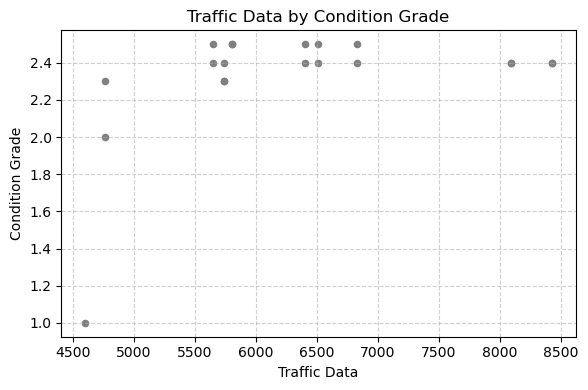

In [14]:
import matplotlib.pyplot as plt

#Query the data
query = f"""
        MATCH (TC:TrafficCounting)-[TC_t]-(r)-[CG_t]-(CG:ConditionGrade)
        WHERE TC_t.time < CG_t.time
        WITH CG,TC, TC_t,r
        ORDER BY TC_t.time DESC
        WITH CG, collect(TC)[0] as traffic,r
        RETURN DISTINCT CG.ConditionGrade as ConditionGrade,toInteger(traffic.TrafficData) as TrafficData,r.Time_ID
        """
result= DB_connection.send_query(query=query)
print("Query sent to the graph database to perform the pattern matching:")
print(query)
print(" --- ")
print(f"Associated data returned based on the {len(result)} found matches:")
print(" ")

# Extract data 
condition_grades = []
traffic_data = []

for element in result:
    print(element)
    condition_grades.append(element["ConditionGrade"])
    traffic_data.append(element["TrafficData"])
    
print(" --- ")
print("Visualization of the data in a Diagramm:")

#display data
# Pair and sort by both X (traffic) and Y (condition)
sorted_data = sorted(zip(traffic_data, condition_grades))  # Sort by X by default
sorted_traffic, sorted_conditions = zip(*sorted_data)



plt.figure(figsize=(6, 4))
plt.scatter(sorted_traffic, sorted_conditions, color="grey", s=20)
plt.xlabel("Traffic Data")
plt.ylabel("Condition Grade")
plt.title("Traffic Data by Condition Grade")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### 2.2 Evaluation of inferred interval time references

If the data records are considered an interval all traffic count data records can be associated with the bridge condition records recorded within the last inspection interval. 

![Temp_Relations_Points](./img/interval_rel.png)

##### 2.2.1 Graph Transformation
The contained event time references are interpreted further to create event time references

In [15]:
query= f"""
        MATCH (t1:ConditionGrade)--(t_ref)
        WITH t1,t_ref
        ORDER BY t1.Date
        WITH collect(t1) as times,t_ref
        WITH times, range(0,size(times)-1) as idxs,t_ref

        UNWIND idxs AS i
        WITH
          times[i] AS current,t_ref,
          CASE WHEN i > 0 THEN times[i-1] ELSE NULL END AS predecessor,
          CASE WHEN i < size(times)-1 THEN times[i+1] ELSE NULL END AS successor
        WHERE predecessor IS NOT NULL
        MERGE (current)-[:start_at{{time:predecessor.Date}}]->(t_ref) 
        MERGE (current)-[:end_at{{time:current.Date}}]->(t_ref)
        
        WITH current,t_ref
        MATCH (current)-[d:start_at{{time:current.Date}}]->(t_ref)
        Delete d"""

DB_connection.send_query(query=query)
print("Query sent to the graph database to perform the graph transformation:")
print(query)
print(" ")

#display the created nodes
query = f"MATCH p=(cg:ConditionGrade)--(t1:Time_ReferenceElement)--(c:TrafficCounting) RETURN p"
print("Visualization of the resulting graph:")
g.show_cypher(cypher=query)

Query sent to the graph database to perform the graph transformation:

        MATCH (t1:ConditionGrade)--(t_ref)
        WITH t1,t_ref
        ORDER BY t1.Date
        WITH collect(t1) as times,t_ref
        WITH times, range(0,size(times)-1) as idxs,t_ref

        UNWIND idxs AS i
        WITH
          times[i] AS current,t_ref,
          CASE WHEN i > 0 THEN times[i-1] ELSE NULL END AS predecessor,
          CASE WHEN i < size(times)-1 THEN times[i+1] ELSE NULL END AS successor
        WHERE predecessor IS NOT NULL
        MERGE (current)-[:start_at{time:predecessor.Date}]->(t_ref) 
        MERGE (current)-[:end_at{time:current.Date}]->(t_ref)
        
        WITH current,t_ref
        MATCH (current)-[d:start_at{time:current.Date}]->(t_ref)
        Delete d
 
Visualization of the resulting graph:


GraphWidget(layout=Layout(height='800px', width='100%'))

Query sent to the graph database to perform the pattern matching:

        MATCH (TC:TrafficCounting)-[TC_t]-(r)-[CG_t_s:start_at]-(CG:ConditionGrade)
        MATCH (r)-[CG_t_e:end_at]-(CG)
        WHERE TC_t.time <= CG_t_e.time AND TC_t.time >= CG_t_s.time
        RETURN DISTINCT CG.ConditionGrade as ConditionGrade,toInteger(TC.TrafficData) as TrafficData,r.Time_ID
        
 --- 
Associated data returned based on the 44 found matches:
 
<Record ConditionGrade=2.4 TrafficData=7541 r.Time_ID=2>
<Record ConditionGrade=2.4 TrafficData=7134 r.Time_ID=2>
<Record ConditionGrade=2.4 TrafficData=8095 r.Time_ID=2>
<Record ConditionGrade=2.4 TrafficData=8431 r.Time_ID=2>
<Record ConditionGrade=2.4 TrafficData=8294 r.Time_ID=2>
<Record ConditionGrade=2.5 TrafficData=5721 r.Time_ID=2>
<Record ConditionGrade=2.5 TrafficData=5942 r.Time_ID=2>
<Record ConditionGrade=2.5 TrafficData=5513 r.Time_ID=2>
<Record ConditionGrade=2.5 TrafficData=5805 r.Time_ID=2>
<Record ConditionGrade=2.5 TrafficData=6264 r

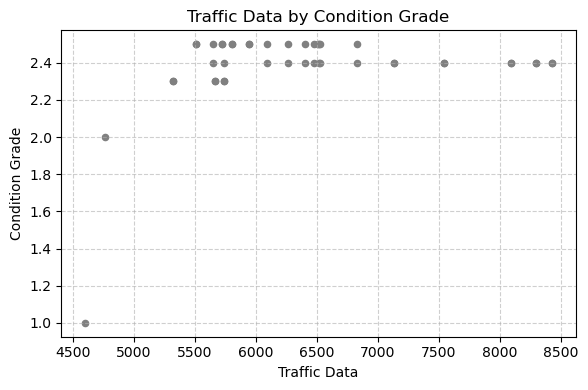

In [139]:
#Query the data
query = f"""
        MATCH (TC:TrafficCounting)-[TC_t]-(r)-[CG_t_s:start_at]-(CG:ConditionGrade)
        MATCH (r)-[CG_t_e:end_at]-(CG)
        WHERE TC_t.time <= CG_t_e.time AND TC_t.time >= CG_t_s.time
        RETURN DISTINCT CG.ConditionGrade as ConditionGrade,toInteger(TC.TrafficData) as TrafficData,r.Time_ID
        """
result= DB_connection.send_query(query=query)
print("Query sent to the graph database to perform the pattern matching:")
print(query)
print(" --- ")
print(f"Associated data returned based on the {len(result)} found matches:")
print(" ")

# Extract data 
condition_grades = []
traffic_data = []

for element in result:
    print(element)
    condition_grades.append(element["ConditionGrade"])
    traffic_data.append(element["TrafficData"])
    
print(" --- ")
print("Visualization of the data in a Diagramm:")

#display data
# Pair and sort by both X (traffic) and Y (condition)
sorted_data = sorted(zip(traffic_data, condition_grades))  # Sort by X by default
sorted_traffic, sorted_conditions = zip(*sorted_data)



plt.figure(figsize=(6, 4))
plt.scatter(sorted_traffic, sorted_conditions, color="grey", s=20)
plt.xlabel("Traffic Data")
plt.ylabel("Condition Grade")
plt.title("Traffic Data by Condition Grade")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()